In [11]:
# import findspark
# findspark.init()

# import sys
# from random import random
# from operator import add

# from pyspark.sql import SparkSession


# if __name__ == "__main__":
#     """
#         Usage: pi [partitions]
#     """
#     spark = SparkSession\
#         .builder\
#         .appName("PythonPi")\
#         .getOrCreate()

#     partitions = 2 # int(sys.argv[1]) if len(sys.argv) > 1 else 2
#     n = 100000 * partitions

#     def f(_):
#         x = random() * 2 - 1
#         y = random() * 2 - 1
#         return 1 if x ** 2 + y ** 2 <= 1 else 0

#     count = spark.sparkContext.parallelize(range(1, n + 1), partitions).map(f).reduce(add)
#     print("Pi is roughly %f" % (4.0 * count / n))

# spark.stop()

In [14]:
sc # automatically loaded

<SparkContext master=local[2] appName=PySparkShell>

Imports

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
from pyspark.sql import SparkSession
import pyspark

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Parsing (as `.csv` with ";" separator and a header)

We get spark DataFrame after the parsing (not RDD)

In [272]:
books_url = "./BX-Books.csv"
books_df = spark.read.csv(books_url, sep=";", header=True)
users_url = "./BX-Users.csv"
users_df = spark.read.csv(users_url, sep=";", header=True)
ratings_url = "./BX-Book-Ratings.csv"
ratings_df = spark.read.csv(ratings_url, sep=";", header=True)
print("Before cleaning")
print("Books count: " + str(books_df.count()))
print("Users count: " + str(users_df.count()))
print("Ratings count: " + str(ratings_df.count()))

books_df = books_df.dropna()
users_df = users_df.dropna()
ratings_df = ratings_df.dropna()

users_df = users_df.filter(users_df.Age != "NULL")

print("After cleaning")
print("Books count: " + str(books_df.count()))
print("Users count: " + str(users_df.count()))
print("Ratings count: " + str(ratings_df.count()))

Before cleaning
Books count: 271379
Users count: 278859
Ratings count: 1149780
After cleaning
Books count: 271379
Users count: 168096
Ratings count: 1149780


In [70]:
print(books_df)
print(users_df)
print(ratings_df)

DataFrame[ISBN: string, Book-Title: string, Book-Author: string, Year-Of-Publication: string, Publisher: string, Image-URL-S: string, Image-URL-M: string, Image-URL-L: string]
DataFrame[User-ID: string, Location: string, Age: string]
DataFrame[User-ID: string, ISBN: string, Book-Rating: string]


Column renaming

In [273]:
books_cols = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users_cols = ['userID', 'Location', 'Age']
ratings_cols = ['userID', 'ISBN', 'bookRating']

old_books_cols = books_df.columns
old_users_cols = users_df.columns
old_ratings_cols = ratings_df.columns

# books_df.toDF(*books_cols)
books_df = pyspark.rdd.reduce(lambda data, i: data.withColumnRenamed(old_books_cols[i], books_cols[i]), range(len(old_books_cols)), books_df)
users_df = pyspark.rdd.reduce(lambda data, i: data.withColumnRenamed(old_users_cols[i], users_cols[i]), range(len(old_users_cols)), users_df)
ratings_df = pyspark.rdd.reduce(lambda data, i: data.withColumnRenamed(old_ratings_cols[i], ratings_cols[i]), range(len(old_ratings_cols)), ratings_df)

print(books_df.columns, users_df.columns, ratings_df.columns)

['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL'] ['userID', 'Location', 'Age'] ['userID', 'ISBN', 'bookRating']


In [274]:
from pyspark.sql.types import DoubleType, DecimalType

users_df = users_df.withColumn('Age', users_df['Age'].cast(DoubleType()))
ratings_df = ratings_df.withColumn('bookRating', ratings_df['bookRating'].cast(DoubleType()))

### Ratings ###

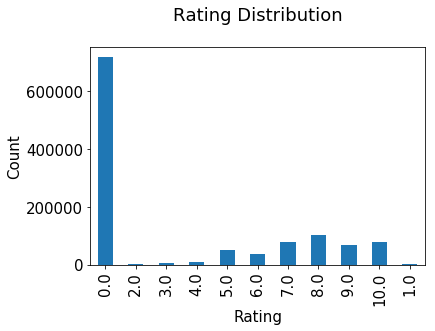

In [250]:
from pyspark.sql.functions import col, countDistinct

# a = ratings_df.agg(*(countDistinct(col(c)).alias(c) for c in ratings_df.columns if c == 'bookRating'))
# ratings_df.agg(countDistinct(col("bookRating")).alias("count"))

ratings_pd = ratings_df.toPandas()
plt.rc("font", size=15)
ratings_pd.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
# plt.savefig('system1.png', bbox_inches='tight')
plt.show()

### Age ###

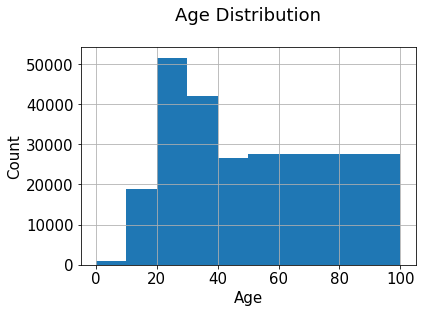

In [251]:
from pyspark.sql.types import DoubleType
users_pd = users_df.toPandas()
pd.to_numeric(users_pd.Age).hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
# plt.savefig('system2.png', bbox_inches='tight')
plt.show()

## Correlation-based recommendations ##

In [275]:
ratings_pd = ratings_df.toPandas()

gisbn_ratings_df = ratings_df.groupBy(['ISBN'])
# average_rating = pd.DataFrame(ratings_pd.groupby('ISBN')['bookRating'].mean())
average_rating = pd.DataFrame()
# average_rating['ratingCount'] = pd.DataFrame(ratings_pd.groupby('ISBN')['bookRating'].count())
# average_rating.sort_values('ratingCount', ascending=False).head()

In [290]:
# avgs = gisbn_ratings_df.avg('bookRating').collect()
# average_rating = pd.DataFrame()

counts = gisbn_ratings_df.count().collect()
ratingCount = [row['count'] for row in counts]
average_rating['ratingCount'] = pd.DataFrame(ratingCount)

2D array: userID / ISBN

In [255]:
counts1 = ratings_pd['userID'].value_counts()
ratings_pd = ratings_pd[ratings_pd['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings_pd['bookRating'].value_counts()
ratings_pd = ratings_pd[ratings_pd['bookRating'].isin(counts[counts >= 100].index)]

ratings_pivot = ratings_pd.pivot(index='userID', columns='ISBN').bookRating
userID = ratings_pivot.index
ISBN = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

(905, 207699)


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,...,THECATASTROPH,THEFLYINGACE,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,b00005wz75,cn108465,cn113107,Խcrosoft
userID,,,,,,,,,,,,,,,,,,,,,
100459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Correlated books to the most popular one - ISBN: 0971880107; Title: "Wild Animus":

In [289]:
book = ratings_pivot['0971880107']
similar_to_chosen = ratings_pivot.corrwith(book)
corr_books = pd.DataFrame(similar_to_chosen, columns=['pearsonR'])
corr_books.dropna(inplace=True)
corr_summary = corr_books.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=300].sort_values('pearsonR', ascending=False).head(10)

/home/abay/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3154: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/abay/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:3088: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,pearsonR,ratingCount
ISBN,,
